In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import tokenize

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Markdown, display, clear_output
from tqdm import tqdm

### Pretty Printing

In [4]:
def printBold(string):
    display(Markdown('**' + string + '**'))

# Reading Data

In [ ]:
train = pd.read_json('/content/drive/My Drive/Capstone Project/Data/train-v1.1.json')
# train = pd.read_json('Data/train-v1.1.json')
train.head()

,data,version
0,"{'title': 'University_of_Notre_Dame', 'paragra...",1.1
1,"{'title': 'Beyoncé', 'paragraphs': [{'context'...",1.1
2,"{'title': 'Montana', 'paragraphs': [{'context'...",1.1
3,"{'title': 'Genocide', 'paragraphs': [{'context...",1.1
4,"{'title': 'Antibiotics', 'paragraphs': [{'cont...",1.1


In [ ]:
test = pd.read_json('/content/drive/My Drive/Capstone Project/Data/dev-v1.1.json')
# test = pd.read_json('Data/dev-v1.1.json')
test.head()

,data,version
0,"{'title': 'Super_Bowl_50', 'paragraphs': [{'co...",1.1
1,"{'title': 'Warsaw', 'paragraphs': [{'context':...",1.1
2,"{'title': 'Normans', 'paragraphs': [{'context'...",1.1
3,"{'title': 'Nikola_Tesla', 'paragraphs': [{'con...",1.1
4,"{'title': 'Computational_complexity_theory', '...",1.1


# Data Preprocessing

## Understanding Data

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     442 non-null    object 
 1   version  442 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.0+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     48 non-null     object 
 1   version  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 896.0+ bytes


As we are exploring the data we can merge training and development data

In [ ]:
df = pd.concat([train,test],ignore_index=True)
df.head()

,data,version
0,"{'title': 'University_of_Notre_Dame', 'paragra...",1.1
1,"{'title': 'Beyoncé', 'paragraphs': [{'context'...",1.1
2,"{'title': 'Montana', 'paragraphs': [{'context'...",1.1
3,"{'title': 'Genocide', 'paragraphs': [{'context...",1.1
4,"{'title': 'Antibiotics', 'paragraphs': [{'cont...",1.1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     490 non-null    object 
 1   version  490 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.8+ KB


1. Data is availble for 490 articles
2. There are no missing values

### Removing redundant data

In [ ]:
df['version'].value_counts()

1.1    490
Name: version, dtype: int64

Since version has only single value we can drop it

In [ ]:
df = df.drop('version',axis=1)
df.head()

,data
0,"{'title': 'University_of_Notre_Dame', 'paragra..."
1,"{'title': 'Beyoncé', 'paragraphs': [{'context'..."
2,"{'title': 'Montana', 'paragraphs': [{'context'..."
3,"{'title': 'Genocide', 'paragraphs': [{'context..."
4,"{'title': 'Antibiotics', 'paragraphs': [{'cont..."


### Analyzing single record

In [ ]:
df.data.astype('str').str.len().sort_values()

212      7788
72       8760
79      13636
116     14100
123     15862
        ...  
466    200311
448    200985
19     209224
11     238801
442    246922
Name: data, Length: 490, dtype: int64

In [ ]:
df['data'].iloc[77]

{'paragraphs': [{'context': 'The Royal Institute of British Architects (RIBA) is a professional body for architects primarily in the United Kingdom, but also internationally, founded for the advancement of architecture under its charter granted in 1837 and Supplemental Charter granted in 1971.',
   'qas': [{'answers': [{'answer_start': 4,
       'text': 'Royal Institute of British Architects'}],
     'id': '56e70a356fe0821900b8ec90',
     'question': 'What does RIBA stand for?'},
    {'answers': [{'answer_start': 158,
       'text': 'the advancement of architecture'}],
     'id': '56e70a356fe0821900b8ec91',
     'question': 'What is the goal of RIBA?'},
    {'answers': [{'answer_start': 219, 'text': '1837'}],
     'id': '56e70a356fe0821900b8ec92',
     'question': 'When was RIBA founded?'},
    {'answers': [{'answer_start': 260, 'text': '1971'}],
     'id': '56e70a356fe0821900b8ec93',
     'question': "When was RIBA's founding document expanded?"},
    {'answers': [{'answer_start': 104

In [ ]:
df['data'].iloc[0]

{'paragraphs': [{'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
   'qas': [{'answers': [{'answer_start': 515,
       'text': 'Saint Bernadette Soubirous'}],
     'id': '5733be284776f41900661182',
     'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?'},
    {'answers': [{'answer_start': 188, 'text': 

In [ ]:
df['data'].iloc[1]

{'paragraphs': [{'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
   'qas': [{'answers': [{'answer_start': 269, 'text': 'in the late 1990s'}],
     'id': '56be85543aeaaa14008c9063',
     'question': 'When did Beyonce start becoming popular?'},
    {'answers': [{'answer_start': 207, 'text': 'singing and dancing'}],
     'id': '56be85543

1. Title: It is the title of the topic
2. paragraphs: Multiple paragraphs(context) related to the topic
3. qas: Questions and Answers w.r.t. each context
4. qas also has 'id' for every question

As data consists of these 3 parts we can divide them into separate columns

## Data wrangling

In [ ]:
# Title and paragraph split
df_title = df['data'].apply(pd.Series) #splits title and paragraphs
df_title.head()

,title,paragraphs
0,University_of_Notre_Dame,"[{'context': 'Architecturally, the school has ..."
1,Beyoncé,[{'context': 'Beyoncé Giselle Knowles-Carter (...
2,Montana,[{'context': 'Montana i/mɒnˈtænə/ is a state i...
3,Genocide,"[{'context': 'The phrase ""in whole or in part""..."
4,Antibiotics,[{'context': 'The emergence of resistance of b...


**Let's do some analysis on the titles**

In [ ]:
df_title['title'].value_counts().sort_values()

Raleigh,_North_Carolina          1
Aspirated_consonant              1
Nintendo_Entertainment_System    1
Iran                             1
Police                           1
                                ..
Internet_service_provider        1
Pacific_War                      1
Namibia                          1
Federalism                       1
Religion_in_ancient_Rome         1
Name: title, Length: 490, dtype: int64

All the titles are unique

In [ ]:
df_title['title'][:25]

0                           University_of_Notre_Dame
1                                            Beyoncé
2                                            Montana
3                                           Genocide
4                                        Antibiotics
5                                    Frédéric_Chopin
6     Sino-Tibetan_relations_during_the_Ming_dynasty
7                                               IPod
8             The_Legend_of_Zelda:_Twilight_Princess
9                                Spectre_(2015_film)
10                           2008_Sichuan_earthquake
11                                     New_York_City
12                             To_Kill_a_Mockingbird
13                                      Solar_energy
14                                        Tajikistan
15                                      Anthropology
16                                          Portugal
17                                        Kanye_West
18                                          Bu

1. Titles are from multiple domains (Singers, Geographic, Historic, Religious, News, Medical, etc.) 
2. Since titls are pretty random and to be from different locations and domains we can't categorize them into subgroups.

Let's do further analysis

In [ ]:
# paragraphs count per title
df_title['para_cnt'] = df_title['paragraphs'].str.len()
df_title.head()

,title,paragraphs,para_cnt
0,University_of_Notre_Dame,"[{'context': 'Architecturally, the school has ...",55
1,Beyoncé,[{'context': 'Beyoncé Giselle Knowles-Carter (...,66
2,Montana,[{'context': 'Montana i/mɒnˈtænə/ is a state i...,44
3,Genocide,"[{'context': 'The phrase ""in whole or in part""...",26
4,Antibiotics,[{'context': 'The emergence of resistance of b...,26


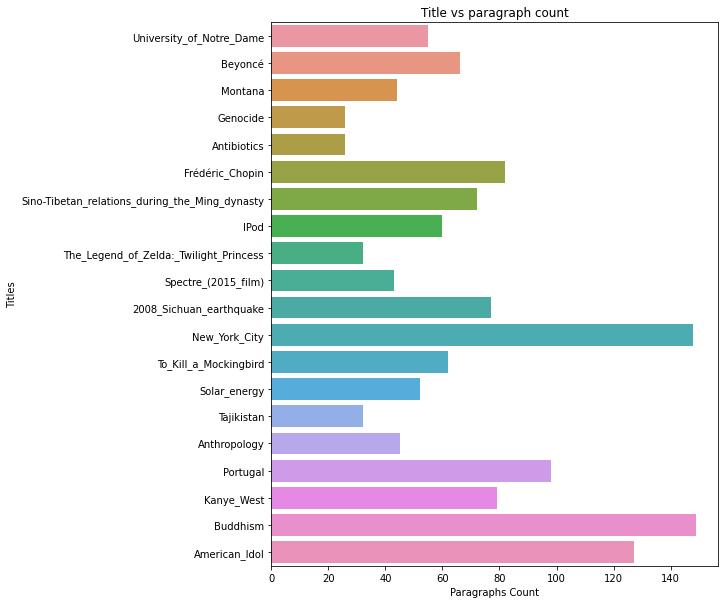

In [ ]:
plt.figure(figsize=(8,10))
sns.barplot(df_title['para_cnt'][:20], df_title['title'][:20])
plt.title("Title vs paragraph count")
plt.ylabel('Titles')
plt.xlabel('Paragraphs Count')
plt.show()

1. Multiple paragraphs are available for each title
2. There are 55 paragraphs available for title "University of Notre Dame", 66 for "Beyoncé"

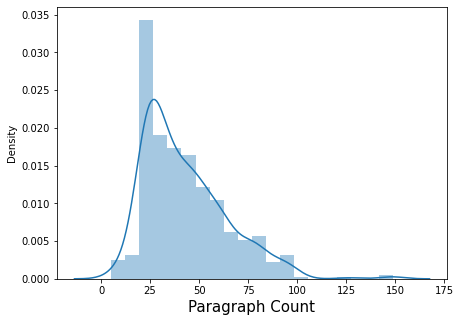

In [ ]:
plt.figure(figsize=(7,5))
sns.distplot(df_title['para_cnt'])
plt.xlabel('Paragraph Count', size=15)
plt.show()

In [ ]:
df_title.describe()

,para_cnt
count,490.000000
mean,42.781633
std,21.419542
min,5.000000
25%,26.000000
50%,38.000000
75%,55.000000
max,149.000000


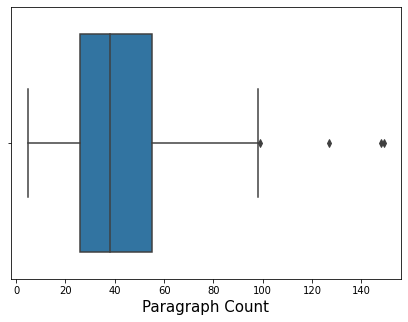

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(df_title['para_cnt'])
plt.xlabel('Paragraph Count', size=15)
plt.show()

1. There are topics with 149 paragraphs.
2. let's check which topics have more than 100 paragraphs

In [ ]:
df_title[df_title['para_cnt'] >= 100]

,title,paragraphs,para_cnt
11,New_York_City,[{'context': 'New York—often called New York C...,148
18,Buddhism,[{'context': 'Buddhism /ˈbudɪzəm/ is a nonthei...,149
19,American_Idol,[{'context': 'American Idol is an American sin...,127


In [ ]:
df_title.sort_values('para_cnt').head()

,title,paragraphs,para_cnt
212,Myocardial_infarction,[{'context': 'Myocardial infarction (MI) or ac...,5
72,Matter,"[{'context': 'Before the 20th century, the ter...",5
123,Grape,[{'context': 'Grapes are a type of fruit that ...,10
116,Pitch_(music),[{'context': 'Pitch is an auditory sensation i...,10
114,Letter_case,[{'context': 'The terms upper case and lower c...,12


The paragraphs count for titles ranges from 5-149

Let's split paragraphs and QnA's further

In [ ]:
# fetch paragraphs and questions data from paragraphs column
df_title['paragraphs'].apply(lambda x: pd.DataFrame(x)).iloc[0]

,context,qas
0,"Architecturally, the school has a Catholic cha...","[{'answers': [{'answer_start': 515, 'text': 'S..."
1,"As at most other universities, Notre Dame's st...","[{'answers': [{'answer_start': 248, 'text': 'S..."
2,The university is the major seat of the Congre...,"[{'answers': [{'answer_start': 119, 'text': 'R..."
3,The College of Engineering was established in ...,"[{'answers': [{'answer_start': 487, 'text': 'e..."
4,All of Notre Dame's undergraduate students are...,"[{'answers': [{'answer_start': 496, 'text': 'L..."
5,"The university first offered graduate degrees,...","[{'answers': [{'answer_start': 358, 'text': '1..."
6,The Joan B. Kroc Institute for International P...,"[{'answers': [{'answer_start': 4, 'text': 'Joa..."
7,The library system of the university is divide...,"[{'answers': [{'answer_start': 136, 'text': '1..."
8,Notre Dame is known for its competitive admiss...,"[{'answers': [{'answer_start': 109, 'text': '3..."
9,"In 2015-2016, Notre Dame ranked 18th overall a...","[{'answers': [{'answer_start': 32, 'text': '18..."


In [ ]:
df_split = pd.DataFrame(dict(
                title=df_title['title'].values.repeat(df_title['paragraphs'].str.len()),
                )).join(pd.DataFrame(df_title['paragraphs'].sum()))
df_split.head()

,title,context,qas
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...","[{'answers': [{'answer_start': 515, 'text': 'S..."
1,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...","[{'answers': [{'answer_start': 248, 'text': 'S..."
2,University_of_Notre_Dame,The university is the major seat of the Congre...,"[{'answers': [{'answer_start': 119, 'text': 'R..."
3,University_of_Notre_Dame,The College of Engineering was established in ...,"[{'answers': [{'answer_start': 487, 'text': 'e..."
4,University_of_Notre_Dame,All of Notre Dame's undergraduate students are...,"[{'answers': [{'answer_start': 496, 'text': 'L..."


In [ ]:
df_split[df_split['title'] == 'University_of_Notre_Dame']

,title,context,qas
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...","[{'answers': [{'answer_start': 515, 'text': 'S..."
1,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...","[{'answers': [{'answer_start': 248, 'text': 'S..."
2,University_of_Notre_Dame,The university is the major seat of the Congre...,"[{'answers': [{'answer_start': 119, 'text': 'R..."
3,University_of_Notre_Dame,The College of Engineering was established in ...,"[{'answers': [{'answer_start': 487, 'text': 'e..."
4,University_of_Notre_Dame,All of Notre Dame's undergraduate students are...,"[{'answers': [{'answer_start': 496, 'text': 'L..."
5,University_of_Notre_Dame,"The university first offered graduate degrees,...","[{'answers': [{'answer_start': 358, 'text': '1..."
6,University_of_Notre_Dame,The Joan B. Kroc Institute for International P...,"[{'answers': [{'answer_start': 4, 'text': 'Joa..."
7,University_of_Notre_Dame,The library system of the university is divide...,"[{'answers': [{'answer_start': 136, 'text': '1..."
8,University_of_Notre_Dame,Notre Dame is known for its competitive admiss...,"[{'answers': [{'answer_start': 109, 'text': '3..."
9,University_of_Notre_Dame,"In 2015-2016, Notre Dame ranked 18th overall a...","[{'answers': [{'answer_start': 32, 'text': '18..."


As we can see paragraph splits are matching with individual output. we can confirm that the splits are done correctly

**Size of data**

In [ ]:
titles_count = df_split['title'].nunique()
paragraphs_count = df_split['context'].nunique()
questions_count = df_split['qas'].str.len().sum()

print("Titles:",titles_count)
print("Paragraphs:",paragraphs_count)
print("Questions:",questions_count)

Titles: 490
Paragraphs: 20958
Questions: 98169


In [ ]:
df_split['qas_cnt'] = df_split['qas'].str.len()
df_split.head()

,title,context,qas,qas_cnt
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...","[{'answers': [{'answer_start': 515, 'text': 'S...",5
1,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...","[{'answers': [{'answer_start': 248, 'text': 'S...",5
2,University_of_Notre_Dame,The university is the major seat of the Congre...,"[{'answers': [{'answer_start': 119, 'text': 'R...",5
3,University_of_Notre_Dame,The College of Engineering was established in ...,"[{'answers': [{'answer_start': 487, 'text': 'e...",5
4,University_of_Notre_Dame,All of Notre Dame's undergraduate students are...,"[{'answers': [{'answer_start': 496, 'text': 'L...",4


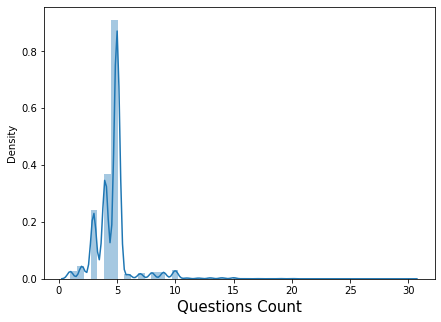

In [ ]:
plt.figure(figsize=(7,5))
sns.distplot(df_split['qas_cnt'])
plt.xlabel('Questions Count', size=15)
plt.show()

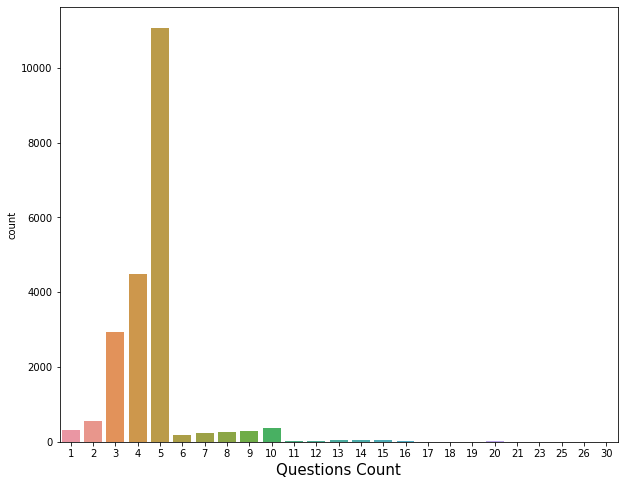

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(df_split['qas_cnt'])
plt.xlabel('Questions Count', size=15)
plt.show()

In [ ]:
df_split.describe()

,qas_cnt
count,20963.000000
mean,4.682965
std,1.762669
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,30.000000


1. Most pargraphs have 4-5 questions.
2. **Assumption**: Short paragraphs will less number of questions(we have paragraphs where only 1 question) where as Big paragraphs will have more number of questions(we also have paragraphs with 30 questions)

  Let's check our assumption

In [ ]:
# count of words in paragraph
df_split['context_len'] = df_split.context.str.split().str.len()
df_split.head()

,title,context,qas,qas_cnt,context_len
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...","[{'answers': [{'answer_start': 515, 'text': 'S...",5,124
1,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...","[{'answers': [{'answer_start': 248, 'text': 'S...",5,216
2,University_of_Notre_Dame,The university is the major seat of the Congre...,"[{'answers': [{'answer_start': 119, 'text': 'R...",5,112
3,University_of_Notre_Dame,The College of Engineering was established in ...,"[{'answers': [{'answer_start': 487, 'text': 'e...",5,101
4,University_of_Notre_Dame,All of Notre Dame's undergraduate students are...,"[{'answers': [{'answer_start': 496, 'text': 'L...",4,114


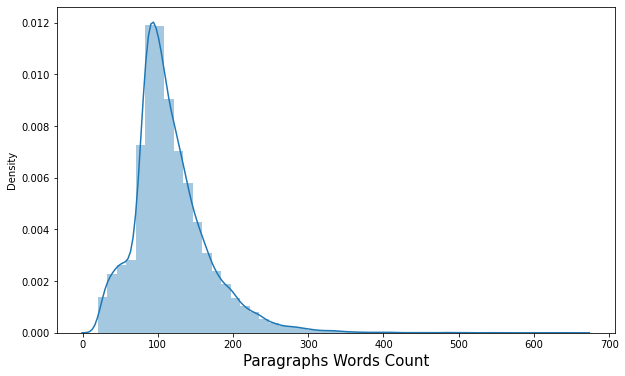

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(df_split['context_len'])
plt.xlabel('Paragraphs Words Count', size=15)
plt.show()

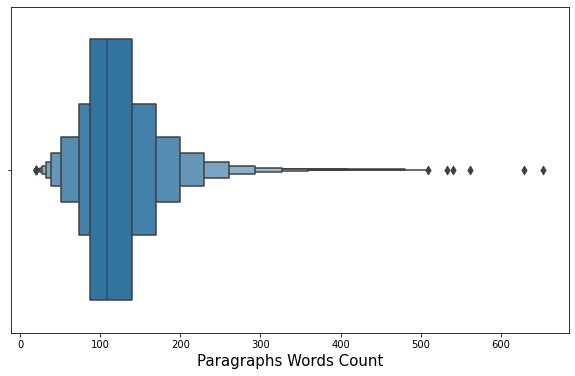

In [ ]:
plt.figure(figsize=(10,6))
sns.boxenplot(df_split['context_len'])
plt.xlabel('Paragraphs Words Count', size=15)
plt.show()

In [ ]:
df_split.describe()

,qas_cnt,context_len
count,20963.000000,20963.000000
mean,4.682965,117.236512
std,1.762669,50.271048
min,1.000000,20.000000
25%,4.000000,87.000000
50%,5.000000,108.000000
75%,5.000000,140.000000
max,30.000000,653.000000


1. Paragraphs have 108-120 words on average
2. We also have some extreme values for which word count is 20 and 653

Questions = 1

In [ ]:
df_split[df_split['qas_cnt'] == 1].head()

,title,context,qas,qas_cnt,context_len
123,Montana,The state song was not composed until 21 years...,"[{'answers': [{'answer_start': 140, 'text': '1...",1,170
125,Montana,The state also has five Micropolitan Statistic...,"[{'answers': [{'answer_start': 628, 'text': '3...",1,133
143,Montana,Vegetation of the state includes lodgepole pin...,"[{'answers': [{'answer_start': 196, 'text': 'a...",1,75
299,Sino-Tibetan_relations_during_the_Ming_dynasty,The exact nature of relations between Tibet an...,"[{'answers': [{'answer_start': 274, 'text': 'M...",1,181
330,Sino-Tibetan_relations_during_the_Ming_dynasty,Dawa Norbu argues that modern Chinese Communis...,"[{'answers': [{'answer_start': 0, 'text': 'Daw...",1,94


There are same titles with only 1 count per paragraph. Let's check unique titles for which we only have one question per paragraph

In [ ]:
title_qna_1 = df_split[df_split['qas_cnt'] == 1]['title'].unique()
title_qna_1

array(['Montana', 'Sino-Tibetan_relations_during_the_Ming_dynasty',
       'IPod', 'New_York_City', 'To_Kill_a_Mockingbird', 'Solar_energy',
       'Kanye_West', 'Buddhism', 'American_Idol', 'Dog',
       '2008_Summer_Olympics_torch_relay', 'Genome', 'Prime_minister',
       'Institute_of_technology', 'Wayback_Machine', 'Symbiosis',
       'Canadian_Armed_Forces', 'Cardinal_(Catholicism)',
       'Iranian_languages', 'Lighting',
       'Separation_of_powers_under_the_United_States_Constitution',
       'Human_Development_Index', 'BBC_Television',
       'Arnold_Schwarzenegger', 'Heresy', 'Warsaw_Pact', 'Materialism',
       'Space_Race', 'Pub', 'Christian', 'Sony_Music_Entertainment',
       'Oklahoma_City', 'Internet_service_provider', 'Comics',
       'Aspirated_consonant', 'Hydrogen', 'Web_browser',
       'BeiDou_Navigation_Satellite_System', 'Catalan_language',
       'Estonian_language', 'Paper', 'Adult_contemporary_music',
       'Westminster_Abbey', 'Bern', 'Tristan_da_Cunha',


In [ ]:
len(title_qna_1)

64

In [ ]:
data = df_split[df_split['qas_cnt'] == 1].iloc[0]

title_name = data['title']
paragraph = data['context']
QnA = data['qas']
para_len = data['context_len']

printBold('Title')
print(title_name)
printBold("Paragraph")
print(paragraph)
print("Paragraph words count:", para_len)
printBold("Question and Answer info")
print(QnA)

**Title**

Montana


**Paragraph**

The state song was not composed until 21 years after statehood, when a musical troupe led by Joseph E. Howard stopped in Butte in September 1910. A former member of the troupe who lived in Butte buttonholed Howard at an after-show party, asking him to compose a song about Montana and got another partygoer, the city editor for the Butte Miner newspaper, Charles C. Cohan, to help. The two men worked up a basic melody and lyrics in about a half-hour for the entertainment of party guests, then finished the song later that evening, with an arrangement worked up the following day. Upon arriving in Helena, Howard's troupe performed 12 encores of the new song to an enthusiastic audience and the governor proclaimed it the state song on the spot, though formal legislative recognition did not occur until 1945. Montana is one of only three states to have a "state ballad", "Montana Melody", chosen by the legislature in 1983. Montana was the first state to also adopt a State Lullaby.
Paragraph words

**Question and Answer info**

[{'answers': [{'answer_start': 140, 'text': '1910'}], 'question': 'When was the state song composed?', 'id': '5733d7fd4776f41900661342'}]


In [ ]:
data = df_split[df_split['qas_cnt'] == 1].iloc[10]

title_name = data['title']
paragraph = data['context']
QnA = data['qas']
para_len = data['context_len']

printBold('Title')
print(title_name)
printBold("Paragraph")
print(paragraph)
print("Paragraph words count:", para_len)
printBold("Question and Answer info")
print(QnA)

**Title**

New_York_City


**Paragraph**

Mass transit in New York City, most of which runs 24 hours a day, accounts for one in every three users of mass transit in the United States, and two-thirds of the nation's rail riders live in the New York City Metropolitan Area.
Paragraph words count: 43


**Question and Answer info**

[{'answers': [{'answer_start': 146, 'text': 'two-thirds'}], 'question': 'What fraction of United States rail riders call the New York City Metropolitan Area home?', 'id': '56d1109d17492d1400aab894'}]


Paragraphs with average number of questions

In [ ]:
df_split[df_split['qas_cnt'].isin([4,5])].head(7)

,title,context,qas,qas_cnt,context_len
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...","[{'answers': [{'answer_start': 515, 'text': 'S...",5,124
1,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...","[{'answers': [{'answer_start': 248, 'text': 'S...",5,216
2,University_of_Notre_Dame,The university is the major seat of the Congre...,"[{'answers': [{'answer_start': 119, 'text': 'R...",5,112
3,University_of_Notre_Dame,The College of Engineering was established in ...,"[{'answers': [{'answer_start': 487, 'text': 'e...",5,101
4,University_of_Notre_Dame,All of Notre Dame's undergraduate students are...,"[{'answers': [{'answer_start': 496, 'text': 'L...",4,114
5,University_of_Notre_Dame,"The university first offered graduate degrees,...","[{'answers': [{'answer_start': 358, 'text': '1...",5,219
6,University_of_Notre_Dame,The Joan B. Kroc Institute for International P...,"[{'answers': [{'answer_start': 4, 'text': 'Joa...",5,97


In [ ]:
data = df_split[df_split['qas_cnt'].isin([4,5])].iloc[0]

title_name = data['title']
paragraph = data['context']
QnA = data['qas']
para_len = data['context_len']

printBold('Title')
print(title_name)
printBold("Paragraph")
print(paragraph)
print("Paragraph words count:", para_len)
printBold("Question and Answer info")
print(QnA)

**Title**

University_of_Notre_Dame


**Paragraph**

Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Paragraph words count: 124


**Question and Answer info**

[{'answers': [{'answer_start': 515, 'text': 'Saint Bernadette Soubirous'}], 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'id': '5733be284776f41900661182'}, {'answers': [{'answer_start': 188, 'text': 'a copper statue of Christ'}], 'question': 'What is in front of the Notre Dame Main Building?', 'id': '5733be284776f4190066117f'}, {'answers': [{'answer_start': 279, 'text': 'the Main Building'}], 'question': 'The Basilica of the Sacred heart at Notre Dame is beside to which structure?', 'id': '5733be284776f41900661180'}, {'answers': [{'answer_start': 381, 'text': 'a Marian place of prayer and reflection'}], 'question': 'What is the Grotto at Notre Dame?', 'id': '5733be284776f41900661181'}, {'answers': [{'answer_start': 92, 'text': 'a golden statue of the Virgin Mary'}], 'question': 'What sits on top of the Main Building at Notre Dame?', 'id': '5733be284776f4190066117e'}]


In [ ]:
data = df_split[df_split['qas_cnt'].isin([4,5])].iloc[4]

title_name = data['title']
paragraph = data['context']
QnA = data['qas']
para_len = data['context_len']

printBold('Title')
print(title_name)
printBold("Paragraph")
print(paragraph)
print("Paragraph words count:", para_len)
printBold("Question and Answer info")
print(QnA)

**Title**

University_of_Notre_Dame


**Paragraph**

All of Notre Dame's undergraduate students are a part of one of the five undergraduate colleges at the school or are in the First Year of Studies program. The First Year of Studies program was established in 1962 to guide incoming freshmen in their first year at the school before they have declared a major. Each student is given an academic advisor from the program who helps them to choose classes that give them exposure to any major in which they are interested. The program also includes a Learning Resource Center which provides time management, collaborative learning, and subject tutoring. This program has been recognized previously, by U.S. News & World Report, as outstanding.
Paragraph words count: 114


**Question and Answer info**

[{'answers': [{'answer_start': 496, 'text': 'Learning Resource Center'}], 'question': 'What entity provides help with the management of time for new students at Notre Dame?', 'id': '5733a70c4776f41900660f64'}, {'answers': [{'answer_start': 68, 'text': 'five'}], 'question': 'How many colleges for undergraduates are at Notre Dame?', 'id': '5733a70c4776f41900660f62'}, {'answers': [{'answer_start': 155, 'text': 'The First Year of Studies program'}], 'question': 'What was created at Notre Dame in 1962 to assist first year students?', 'id': '5733a70c4776f41900660f63'}, {'answers': [{'answer_start': 647, 'text': 'U.S. News & World Report'}], 'question': 'Which organization declared the First Year of Studies program at Notre Dame "outstanding?"', 'id': '5733a70c4776f41900660f65'}]


Paragraphs with more than average number of questions

In [ ]:
df_split[df_split['qas_cnt'] >= 10].head()

,title,context,qas,qas_cnt,context_len
55,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"[{'answers': [{'answer_start': 269, 'text': 'i...",20,109
56,Beyoncé,Following the disbandment of Destiny's Child i...,"[{'answers': [{'answer_start': 207, 'text': 'a...",12,160
57,Beyoncé,"A self-described ""modern-day feminist"", Beyonc...","[{'answers': [{'answer_start': 104, 'text': 'l...",12,176
58,Beyoncé,"Beyoncé Giselle Knowles was born in Houston, T...","[{'answers': [{'answer_start': 303, 'text': ""D...",13,93
59,Beyoncé,Beyoncé attended St. Mary's Elementary School ...,"[{'answers': [{'answer_start': 49, 'text': 'Fr...",11,124


In [ ]:
title_qna_10 = df_split[df_split['qas_cnt'] >= 10]['title'].unique()
title_qna_10

array(['Beyoncé', 'Genocide', 'Antibiotics', 'Frédéric_Chopin', 'IPod',
       'The_Legend_of_Zelda:_Twilight_Princess', 'Spectre_(2015_film)',
       '2008_Sichuan_earthquake', 'New_York_City', 'Tajikistan',
       'Portugal', 'Buddhism', 'American_Idol', 'Dog',
       '2008_Summer_Olympics_torch_relay', 'Alfred_North_Whitehead',
       'Lighting', 'Architecture',
       'Russian_Soviet_Federative_Socialist_Republic',
       'Universal_Studios', 'Boston', 'Communications_in_Somalia',
       'Estonian_language', 'Arena_Football_League', 'Westminster_Abbey',
       'Nanjing', 'Classical_music', 'Marshall_Islands', 'Houston',
       'Imperial_College_London', 'Gymnastics', 'FC_Barcelona',
       'Federal_Bureau_of_Investigation', 'Adolescence', 'Antarctica',
       'Melbourne', 'Sanskrit', 'Sexual_orientation',
       'Athanasius_of_Alexandria', 'Multiracial_American',
       'Pharmaceutical_industry', 'Queen_Victoria', 'Freemasonry',
       'Hellenistic_period', 'Napoleon', 'Northwester

In [ ]:
len(title_qna_10)

92

Looking at the results our assumption (number of questions depends on the size of words in paragraph) fails as we can see paragraphs with more than 150 words have 1 question whereas paragrphs with around 100-125 words have around 15-20 questions

**Assumption**: As multiple questions are available for a single paragraph. Question will probably from some sentence and it's answer will be part of that sentence

### Analysis on Paragraphs and Question/Answers

In [ ]:
# creating unique for joining questions and answers split
df_split['title_para'] = df_split['title'].astype('str') + df_split['context'].astype('str') + df_split['qas'].astype('str')
df_split.head()

,title,context,qas,qas_cnt,context_len,title_para
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...","[{'answers': [{'answer_start': 515, 'text': 'S...",5,124,"University_of_Notre_DameArchitecturally, the s..."
1,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...","[{'answers': [{'answer_start': 248, 'text': 'S...",5,216,University_of_Notre_DameAs at most other unive...
2,University_of_Notre_Dame,The university is the major seat of the Congre...,"[{'answers': [{'answer_start': 119, 'text': 'R...",5,112,University_of_Notre_DameThe university is the ...
3,University_of_Notre_Dame,The College of Engineering was established in ...,"[{'answers': [{'answer_start': 487, 'text': 'e...",5,101,University_of_Notre_DameThe College of Enginee...
4,University_of_Notre_Dame,All of Notre Dame's undergraduate students are...,"[{'answers': [{'answer_start': 496, 'text': 'L...",4,114,University_of_Notre_DameAll of Notre Dame's un...


In [ ]:
#spliting question and answers
df_qas_split = pd.DataFrame(dict(
                title_para=df_split['title_para'].values.repeat(df_split['qas'].str.len()),
                )).join(pd.DataFrame(df_split['qas'].sum()))
print(df_qas_split.shape)
df_qas_split.head()

(98169, 4)


,title_para,answers,question,id
0,"University_of_Notre_DameArchitecturally, the s...","[{'answer_start': 515, 'text': 'Saint Bernadet...",To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182
1,"University_of_Notre_DameArchitecturally, the s...","[{'answer_start': 188, 'text': 'a copper statu...",What is in front of the Notre Dame Main Building?,5733be284776f4190066117f
2,"University_of_Notre_DameArchitecturally, the s...","[{'answer_start': 279, 'text': 'the Main Build...",The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180
3,"University_of_Notre_DameArchitecturally, the s...","[{'answer_start': 381, 'text': 'a Marian place...",What is the Grotto at Notre Dame?,5733be284776f41900661181
4,"University_of_Notre_DameArchitecturally, the s...","[{'answer_start': 92, 'text': 'a golden statue...",What sits on top of the Main Building at Notre...,5733be284776f4190066117e


In [ ]:
# merging QnA data with title and paragraphs
df_qas = df_split.join(df_qas_split.set_index('title_para'), on='title_para')
df_qas = df_qas.drop(['title_para','qas'],axis=1)
df_qas = df_qas.reset_index(drop=True)
print(df_qas.shape)
df_qas.head()

(98169, 7)


,title,context,qas_cnt,context_len,answers,question,id
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,"[{'answer_start': 515, 'text': 'Saint Bernadet...",To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182
1,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,"[{'answer_start': 188, 'text': 'a copper statu...",What is in front of the Notre Dame Main Building?,5733be284776f4190066117f
2,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,"[{'answer_start': 279, 'text': 'the Main Build...",The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180
3,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,"[{'answer_start': 381, 'text': 'a Marian place...",What is the Grotto at Notre Dame?,5733be284776f41900661181
4,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,"[{'answer_start': 92, 'text': 'a golden statue...",What sits on top of the Main Building at Notre...,5733be284776f4190066117e


In [ ]:
# splitting answers
df_qas['answer'] = df_qas['answers'].apply(lambda x: x[0]['text'])
df_qas['answerStart'] = df_qas['answers'].apply(lambda x: x[0]['answer_start'])

In [ ]:
df_qas = df_qas.drop('answers',axis=1)
df_qas.head()

,title,context,qas_cnt,context_len,question,id,answer,answerStart
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182,Saint Bernadette Soubirous,515
1,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What is in front of the Notre Dame Main Building?,5733be284776f4190066117f,a copper statue of Christ,188
2,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180,the Main Building,279
3,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What is the Grotto at Notre Dame?,5733be284776f41900661181,a Marian place of prayer and reflection,381
4,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What sits on top of the Main Building at Notre...,5733be284776f4190066117e,a golden statue of the Virgin Mary,92


As we already have start position of answer in the paragraph. Let's check how question and it's answer is  is formed from sentence

In [ ]:
def extractSentence(para, ans_start):
    
    sentences = tokenize.sent_tokenize(para)
    sentenceStart = 0
    
    for sentence in sentences:
        if (sentenceStart + len(sentence) >= ans_start):
            return sentence         
        
        sentenceStart += len(sentence) + 1

In [ ]:
# fetch sentence containing answer
df_qas['questionSentence'] = df_qas.apply(lambda x: extractSentence(x['context'],x['answerStart']), axis=1)
df_qas.head()

,title,context,qas_cnt,context_len,question,id,answer,answerStart,questionSentence
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182,Saint Bernadette Soubirous,515,"It is a replica of the grotto at Lourdes, Fran..."
1,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What is in front of the Notre Dame Main Building?,5733be284776f4190066117f,a copper statue of Christ,188,Immediately in front of the Main Building and ...
2,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180,the Main Building,279,Next to the Main Building is the Basilica of t...
3,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What is the Grotto at Notre Dame?,5733be284776f41900661181,a Marian place of prayer and reflection,381,"Immediately behind the basilica is the Grotto,..."
4,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What sits on top of the Main Building at Notre...,5733be284776f4190066117e,a golden statue of the Virgin Mary,92,Atop the Main Building's gold dome is a golden...


In [ ]:
def showQuestion(row_id):
    
    data = df_qas.iloc[row_id]
    
    printBold("Title")
    print(data['title'])
    
    printBold("Paragraph")
    print(data['context'])
    
    printBold("Question")
    print(data['question'])

    printBold('Question Sentence')
    print(data['questionSentence'])
    
    printBold("Answer")
    print(data['answer'])
    print("Starts at:",data['answerStart'])

In [ ]:
showQuestion(0)

**Title**

University_of_Notre_Dame


**Paragraph**

Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.


**Question**

To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?


**Question Sentence**

It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.


**Answer**

Saint Bernadette Soubirous
Starts at: 515


In [ ]:
showQuestion(5000)

**Title**

Solar_energy


**Paragraph**

Greenhouses convert solar light to heat, enabling year-round production and the growth (in enclosed environments) of specialty crops and other plants not naturally suited to the local climate. Primitive greenhouses were first used during Roman times to produce cucumbers year-round for the Roman emperor Tiberius. The first modern greenhouses were built in Europe in the 16th century to keep exotic plants brought back from explorations abroad. Greenhouses remain an important part of horticulture today, and plastic transparent materials have also been used to similar effect in polytunnels and row covers.


**Question**

What is one purpose of a greenhouse?


**Question Sentence**

Greenhouses convert solar light to heat, enabling year-round production and the growth (in enclosed environments) of specialty crops and other plants not naturally suited to the local climate.


**Answer**

enabling year-round production and the growth (in enclosed environments) of specialty crops
Starts at: 41


**Question containment in sentence**

In [ ]:
def containedInText(text, question):
    
    questionWords = tokenize.word_tokenize(question.lower())
    textWords = tokenize.word_tokenize(text.lower())
    wordsContained = 0

    for questionWord in questionWords:
        if questionWord in textWords:
            wordsContained += 1
            
    contain_per = round(wordsContained / len(questionWords)*100,2)
    return contain_per

In [ ]:
# fetch first question in data
row_id = 0
data = df_qas.iloc[row_id]
title_name = data['title']
paragraph = data['context']
question = data['question']
answer = data['answer']
answer_start = data['answerStart']
sentence = data['questionSentence']

showQuestion(row_id)
printBold("Sentence")
print(sentence)

contained = containedInText(sentence, question)
print(f"\nPercentage of question words contained in sentence: {contained}%")

contained = containedInText(paragraph, question)
print(f"Percentage of question words contained in paragraph: {contained}%")

**Title**

University_of_Notre_Dame


**Paragraph**

Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.


**Question**

To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?


**Question Sentence**

It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.


**Answer**

Saint Bernadette Soubirous
Starts at: 515


**Sentence**

It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.

Percentage of question words contained in sentence: 64.29%
Percentage of question words contained in paragraph: 57.14%


In [ ]:
row_id = 10000
data = df_qas.iloc[row_id]
title_name = data['title']
paragraph = data['context']
question = data['question']
answer = data['answer']
answer_start = data['answerStart']
sentence = data['questionSentence']

showQuestion(row_id)
printBold("Sentence")
print(sentence)

contained = containedInText(sentence, question)
print(f"\nPercentage of question words contained in sentence: {contained}%")

contained = containedInText(paragraph, question)
print(f"Percentage of question words contained in paragraph: {contained}%")

**Title**

Institute_of_technology


**Paragraph**

In Turkey and the Ottoman Empire, the oldest technical university is Istanbul Technical University. Its graduates contributed to a wide variety of activities in scientific research and development. In 1950s, 2 technical universities were opened in Ankara and Trabzon. In recent years, Yildiz University is reorganized as Yildiz Technical University and 2 institutes of technology were founded in Kocaeli and Izmir. In 2010, another technical university named Bursa Technical University was founded in Bursa. Moreover, a sixth technical university is about to be opened in Konya named Konya Technical University.


**Question**

When Konya Technical University opens, how many total institutes of technology will there be in Turkey and the Ottoman Empire?


**Question Sentence**

Moreover, a sixth technical university is about to be opened in Konya named Konya Technical University.


**Answer**

six
Starts at: 520


**Sentence**

Moreover, a sixth technical university is about to be opened in Konya named Konya Technical University.

Percentage of question words contained in sentence: 27.27%
Percentage of question words contained in paragraph: 63.64%


**Observations:**

There won't be 100% containment simply because the questions will contain question-like words like Why, Who, Whom, What.

In this example we also see that the word 'appear'/'opens' is contained in the original sentence but in past tense. We could take care of that if we take the stems of the words, but we think it's better to see the least imaginative way for forming questions.

We are also counting stopwords/common words like ('to', 'the', 'in') which could be encountered at different places of the sentence, but again we want to measure the least-creative questions.

In first sentece we also see that the question uses the word allegedly which is a synonym of reputedly in the sentence. That could be nice for question forming.

We also see that the question actually encompasses the words around the answer, rather than the entire sentence. Which is a definate must-do when we form our questions.

Let's calculate the score for all questons at both sentence and paragraph level

In [ ]:
df_qas['sentencePercent'] = df_qas.apply(lambda x: containedInText(x['questionSentence'], x['question']), axis=1)
df_qas['paragraphPercent'] = df_qas.apply(lambda x: containedInText(x['context'], x['question']), axis=1)
df_qas.head(20)

,title,context,qas_cnt,context_len,question,id,answer,answerStart,questionSentence,sentencePercent,paragraphPercent
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182,Saint Bernadette Soubirous,515,"It is a replica of the grotto at Lourdes, Fran...",64.29,57.14
1,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What is in front of the Notre Dame Main Building?,5733be284776f4190066117f,a copper statue of Christ,188,Immediately in front of the Main Building and ...,63.64,63.64
2,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180,the Main Building,279,Next to the Main Building is the Basilica of t...,53.33,60.00
3,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What is the Grotto at Notre Dame?,5733be284776f41900661181,a Marian place of prayer and reflection,381,"Immediately behind the basilica is the Grotto,...",37.50,50.00
4,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What sits on top of the Main Building at Notre...,5733be284776f4190066117e,a golden statue of the Virgin Mary,92,Atop the Main Building's gold dome is a golden...,33.33,41.67
5,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...",5,216,When did the Scholastic Magazine of Notre dame...,5733bf84d058e614000b61be,September 1876,248,"Begun as a one-page journal in September 1876,...",27.27,63.64
6,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...",5,216,How often is Notre Dame's the Juggler published?,5733bf84d058e614000b61bf,twice,441,"The other magazine, The Juggler, is released t...",30.00,80.00
7,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...",5,216,What is the daily student paper at Notre Dame ...,5733bf84d058e614000b61c0,The Observer,598,The newspapers have varying publication intere...,36.36,72.73
8,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...",5,216,How many student news papers are found at Notr...,5733bf84d058e614000b61bd,three,126,The nine student-run outlets include three new...,0.00,54.55
9,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...",5,216,In what year did the student paper Common Sens...,5733bf84d058e614000b61c1,1987,908,"In 1987, when some students believed that The ...",26.67,73.33


In [ ]:
df_qas.describe()

,qas_cnt,context_len,answerStart,sentencePercent,paragraphPercent
count,98169.000000,98169.000000,98169.000000,98169.000000,98169.000000
mean,5.346403,120.214436,320.756777,46.393689,58.215991
std,2.488578,50.154182,268.445390,19.038227,15.905951
min,1.000000,20.000000,0.000000,0.000000,0.000000
25%,4.000000,89.000000,111.000000,33.330000,50.000000
50%,5.000000,110.000000,262.000000,46.150000,60.000000
75%,5.000000,142.000000,469.000000,60.000000,70.000000
max,30.000000,653.000000,3126.000000,100.000000,100.000000


1. On average 50% of the words in question are contained in the sentence. Which is a good result.
2. Containment in paragraph is more which generally holds good for any question.

**Let's analyze questions with 0% ontainment in sentence(Record 8).**

In [ ]:
df_qas[df_qas['sentencePercent'] == 0].head(10)

,title,context,qas_cnt,context_len,question,id,answer,answerStart,questionSentence,sentencePercent,paragraphPercent
8,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...",5,216,How many student news papers are found at Notr...,5733bf84d058e614000b61bd,three,126,The nine student-run outlets include three new...,0.0,54.55
49,University_of_Notre_Dame,"Father Joseph Carrier, C.S.C. was Director of ...",5,157,What person was the Director of the Science Mu...,5733b0fb4776f41900661041,"Father Joseph Carrier, C.S.C.",0,"Father Joseph Carrier, C.S.C.",0.0,55.56
53,University_of_Notre_Dame,"Father Joseph Carrier, C.S.C. was Director of ...",5,157,What professorship did Father Josh Carrier hol...,5733b0fb4776f41900661042,Professor of Chemistry and Physics,85,was Director of the Science Museum and the Lib...,0.0,27.27
116,University_of_Notre_Dame,"The Rev. John J. Cavanaugh, C.S.C. served as p...",5,160,Which president did Notre Dame have in 1947?,5733926d4776f41900660d8d,"Rev. John J. Cavanaugh, C.S.C.",4,The Rev.,0.0,55.56
248,University_of_Notre_Dame,"Football gameday traditions During home games,...",5,122,On what day do Notre Dame home football games ...,5733ca05d058e614000b6267,Saturday,424,This tradition involves the drum line of the B...,0.0,63.64
269,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,20,109,When did Beyonce start becoming popular?,56be85543aeaaa14008c9063,in the late 1990s,269,"Born and raised in Houston, Texas, she perform...",0.0,0.00
315,Beyoncé,"Beyoncé Giselle Knowles was born in Houston, T...",13,93,What race was Beyonce's father?,56be892d3aeaaa14008c908d,African-American,330,"Mathew is African-American, while Tina is of L...",0.0,28.57
363,Beyoncé,LeToya Luckett and Roberson became unhappy wit...,10,134,What mental health issue did Beyonce go through?,56be8d423aeaaa14008c90b2,depression,169,Beyoncé experienced depression following the s...,0.0,0.00
364,Beyoncé,LeToya Luckett and Roberson became unhappy wit...,10,134,What event occured after she was publicly crit...,56be8d423aeaaa14008c90b3,boyfriend left her,320,Her long-standing boyfriend left her at this t...,0.0,44.44
505,Beyoncé,"In 2011, documents obtained by WikiLeaks revea...",13,100,When did this leak happen?,56bf9dbda10cfb14005511c6,2011,3,"In 2011, documents obtained by WikiLeaks revea...",0.0,0.00


In [ ]:
showQuestion(8)

**Title**

University_of_Notre_Dame


**Paragraph**

As at most other universities, Notre Dame's students run a number of news media outlets. The nine student-run outlets include three newspapers, both a radio and television station, and several magazines and journals. Begun as a one-page journal in September 1876, the Scholastic magazine is issued twice monthly and claims to be the oldest continuous collegiate publication in the United States. The other magazine, The Juggler, is released twice a year and focuses on student literature and artwork. The Dome yearbook is published annually. The newspapers have varying publication interests, with The Observer published daily and mainly reporting university and other news, and staffed by students from both Notre Dame and Saint Mary's College. Unlike Scholastic and The Dome, The Observer is an independent publication and does not have a faculty advisor or any editorial oversight from the University. In 1987, when some students believed that The Observer began to show a conservative bias, a lib

**Question**

How many student news papers are found at Notre Dame?


**Question Sentence**

The nine student-run outlets include three newspapers, both a radio and television station, and several magazines and journals.


**Answer**

three
Starts at: 126


The question is actually formed from the previous sentence.

In [ ]:
showQuestion(269)

**Title**

Beyoncé


**Paragraph**

Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".


**Question**

When did Beyonce start becoming popular?


**Question Sentence**

Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child.


**Answer**

in the late 1990s
Starts at: 269


A **synonym** case - instead of rose to fame, start becoming popular is used.

In [ ]:
showQuestion(505)

**Title**

Beyoncé


**Paragraph**

In 2011, documents obtained by WikiLeaks revealed that Beyoncé was one of many entertainers who performed for the family of Libyan ruler Muammar Gaddafi. Rolling Stone reported that the music industry was urging them to return the money they earned for the concerts; a spokesperson for Beyoncé later confirmed to The Huffington Post that she donated the money to the Clinton Bush Haiti Fund. Later that year she became the first solo female artist to headline the main Pyramid stage at the 2011 Glastonbury Festival in over twenty years, and was named the highest-paid performer in the world per minute.


**Question**

When did this leak happen?


**Question Sentence**

In 2011, documents obtained by WikiLeaks revealed that Beyoncé was one of many entertainers who performed for the family of Libyan ruler Muammar Gaddafi.


**Answer**

2011
Starts at: 3


That's just a bad question. It could only be asked in combination with the text.

**Let's analyze questions with 100% containment.**

In [ ]:
df_qas[df_qas['sentencePercent'] == 100].head(10)

,title,context,qas_cnt,context_len,question,id,answer,answerStart,questionSentence,sentencePercent,paragraphPercent
21911,Near_East,Some regions beyond the Ottoman Porte were inc...,5,139,The demise of what left considerable confusion...,56f8dfe39b226e1400dd115c,of the sick man of Europe,451,The demise of the sick man of Europe left cons...,100.0,100.0
39394,Bill_%26_Melinda_Gates_Foundation,The foundation has donated billions of dollars...,5,162,The foundation has donated billions to suffere...,5725c87b89a1e219009abe9a,The foundation has donated billions of dollars...,0,The foundation has donated billions of dollars...,100.0,100.0
45064,Florida,"In 2010, 6.9% of the population (1,269,765) co...",3,95,In the 1980 census the largest ancestry group ...,57266a715951b619008f720e,largest ancestry group reported in Florida was...,376,In the 1980 United States census the largest a...,100.0,100.0
48874,Somerset,The University of Bath and Bath Spa University...,4,107,Bath school of pharmacy founded in,5726baf35951b619008f7c2b,Bath School of Pharmacy (founded 1907,249,The University of Bath gained its Royal Charte...,100.0,100.0
53226,Utrecht,"Utrecht city has an active cultural life, and ...",4,166,Cultural life in Utrecht is second to,5726e77d5951b619008f81f5,"Utrecht city has an active cultural life, and ...",0,"Utrecht city has an active cultural life, and ...",100.0,100.0
67425,Energy,Thermodynamics divides energy transformation i...,3,185,A reversible process is one in which this does...,5729fe926aef051400155184,dissipation,406,A reversible process is one in which this sort...,100.0,100.0


In [ ]:
showQuestion(53226)

**Title**

Utrecht


**Paragraph**

Utrecht city has an active cultural life, and in the Netherlands is second only to Amsterdam. There are several theatres and theatre companies. The 1941 main city theatre was built by Dudok. Besides theatres there is a large number of cinemas including three arthouse cinemas. Utrecht is host to the international Early Music Festival (Festival Oude Muziek, for music before 1800) and the Netherlands Film Festival. The city has an important classical music hall Vredenburg (1979 by Herman Hertzberger). Its acoustics are considered among the best of the 20th-century original music halls.[citation needed] The original Vredenburg music hall has been redeveloped as part of the larger station area redevelopment plan and in 2014 has gained additional halls that allowed its merger with the rock club Tivoli and the SJU jazzpodium. There are several other venues for music throughout the city. Young musicians are educated in the conservatory, a department of the Utrecht School of the Arts. There is 

**Question**

Cultural life in Utrecht is second to 


**Question Sentence**

Utrecht city has an active cultural life, and in the Netherlands is second only to Amsterdam.


**Answer**

Utrecht city has an active cultural life, and in the Netherlands is second only to Amsterdam
Starts at: 0


The question words all appear in the sentence, but not in order. But the answer is the entire sentence, which obviously has needless information inside it. Looking further into it, the question is actually wrong, because it should state second in Netherlands. This question should be scrapped.

In [ ]:
showQuestion(67425)

**Title**

Energy


**Paragraph**

Thermodynamics divides energy transformation into two kinds: reversible processes and irreversible processes. An irreversible process is one in which energy is dissipated (spread) into empty energy states available in a volume, from which it cannot be recovered into more concentrated forms (fewer quantum states), without degradation of even more energy. A reversible process is one in which this sort of dissipation does not happen. For example, conversion of energy from one type of potential field to another, is reversible, as in the pendulum system described above. In processes where heat is generated, quantum states of lower energy, present as possible excitations in fields between atoms, act as a reservoir for part of the energy, from which it cannot be recovered, in order to be converted with 100% efficiency into other forms of energy. In this case, the energy must partly stay as heat, and cannot be completely recovered as usable energy, except at the price of an increase in some ot

**Question**

A reversible process is one in which this does not happen.


**Question Sentence**

A reversible process is one in which this sort of dissipation does not happen.


**Answer**

dissipation
Starts at: 406


This is, basically, just the example of question we expect to generate. The answer is removed and the sentence is descriptive enough to fill in the missing word.

**Summary**

---


The assumption that the question is mostly consisted of words from the sentence the answer is in seems correct.

There are some obvious differences like:

*   **Question-like words** are added - who, why, when...
*   **Synonyms** are used instead of the words used in the sentence
*   Changing the sentence to a question also changes the **tense** of the word.
*   In long sentences, only a **part of the sentence is used**. Like if the sentence is separated with commas, the comma actually divides two logical statements.

we also managed to find some outliers which turned out to be not-so-well asked questions.



**Answers**

Couple of ideas to explore:


*   Are all the answers phrases from the text.
*   The type of the answers - number, dates, names, locations, similarity to the title.
*   Part of speech - verb, noun.
*   Answer lenght in words.
*   Words around the answer.
*   Answer location in the sentence - First word, last word, in middle.

## Answers words count

In [ ]:
df_qas['answerWordCount'] = df_qas['answer'].apply(lambda x: len(tokenize.word_tokenize(x)))
df_qas.head()

,title,context,qas_cnt,context_len,question,id,answer,answerStart,questionSentence,sentencePercent,paragraphPercent,answerWordCount
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182,Saint Bernadette Soubirous,515,"It is a replica of the grotto at Lourdes, Fran...",64.29,57.14,3
1,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What is in front of the Notre Dame Main Building?,5733be284776f4190066117f,a copper statue of Christ,188,Immediately in front of the Main Building and ...,63.64,63.64,5
2,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180,the Main Building,279,Next to the Main Building is the Basilica of t...,53.33,60.00,3
3,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What is the Grotto at Notre Dame?,5733be284776f41900661181,a Marian place of prayer and reflection,381,"Immediately behind the basilica is the Grotto,...",37.50,50.00,7
4,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What sits on top of the Main Building at Notre...,5733be284776f4190066117e,a golden statue of the Virgin Mary,92,Atop the Main Building's gold dome is a golden...,33.33,41.67,7


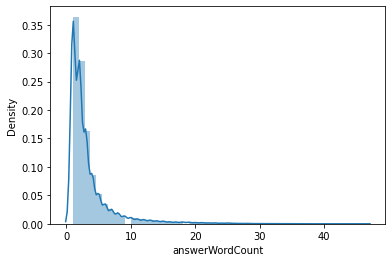

In [ ]:
sns.distplot(df_qas['answerWordCount'])

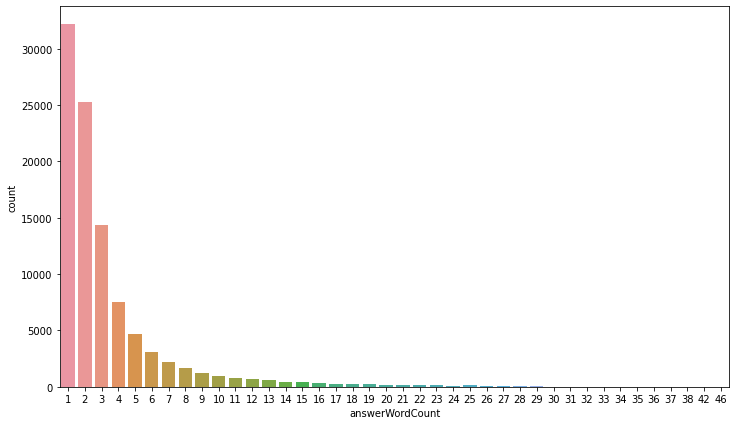

In [ ]:
plt.figure(figsize=(12,7))
sns.countplot(df_qas['answerWordCount'])

In [ ]:
a1 = df_qas['answerWordCount'].value_counts()[:6]
a1

1    32161
2    25233
3    14350
4     7557
5     4654
6     3050
Name: answerWordCount, dtype: int64

In [ ]:
df_qas['answerWordCount'].value_counts()[6:].sum()

11164

In [ ]:
a2 = pd.Series([11164],index = ['>7'])
a2

>7    11164
dtype: int64

In [ ]:
a3 = pd.concat([a1,a2])
a3

1     32161
2     25233
3     14350
4      7557
5      4654
6      3050
>7    11164
dtype: int64

Text(0, 0.5, '')

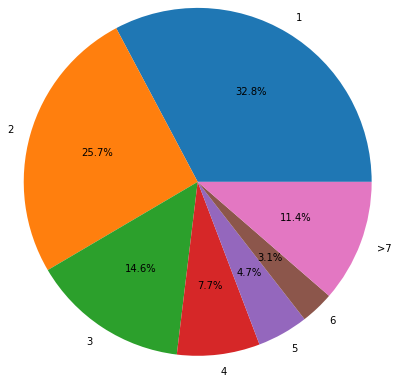

In [ ]:
a3.plot(kind='pie',autopct='%1.1f%%', radius = 2)
# plt.title("Ans")
plt.ylabel('')  

33% of the answers contains one word and 26% contains 2 words.

In [ ]:
df_qas[df_qas['answerWordCount'] == 1][['question','questionSentence','answer','answerWordCount']].sample(10,random_state=0)

,question,questionSentence,answer,answerWordCount
46432,Do the roots and shoots need each other?,The root system and the shoot system are inter...,interdependent,1
28257,What is Michael Graham's profession?,Psychotherapist Michael C. Graham describes al...,Psychotherapist,1
76056,When was Olin Business School founded?,Founded as the School of Commerce and Finance ...,1917,1
34180,Daniel Roche claims that Masonry promoted what...,"On the negative side, Daniel Roche contests cl...",egalitarianism,1
64830,Polymophism species have different forms or wh...,Polymorphism is where a species may have diffe...,morphs,1
83828,When were the gods below and the dead celebrated?,"Chthonic gods such as Dis pater, the di inferi...",nighttime,1
42618,how many ships sailed from Torbay?,"The permission was granted, and despite the de...",three,1
69354,When did Bertrand Russell die?,They saw in the logical symbolism elaborated b...,1970,1
97560,"Who asserted Russia's right to ""self-determina...",Bolshevik leaders had effectively reestablishe...,Lenin,1
79866,What is the age limit on the Olympic men's tou...,The Olympic men's tournament is played at Unde...,Under-23,1


In [ ]:
df_qas[df_qas['answerWordCount'] == 2][['question','questionSentence','answer','answerWordCount']].sample(10,random_state=0)

,question,questionSentence,answer,answerWordCount
33697,What is another term for uranium that is enric...,"According to an interview from the article, on...",weapons grade,2
66544,What is Stable testing also called?,Stability testing (often referred to as load o...,endurance testing,2
4535,Which president won all of NYC in 1924?,New York City has not been carried by a Republ...,Calvin Coolidge,2
27921,What kind of programmes do students work on fo...,Examples of notable student groups and project...,educational development,2
2036,How much did Chopin's funeral and monument cost?,"The expenses of the funeral and monument, amou...","5,000 francs",2
34111,What century produced the first Russian univer...,"In Russia, the government began to actively en...",18th century,2
64585,Who played the mandolin in Vaudeville?,Samuel Siegel played mandolin in Vaudeville an...,Samuel Siegel,2
71271,What is the per capita GDP of Cyprus given by ...,According to the latest International Monetary...,"$30,769",2
26330,A defeat by which team eliminated England from...,England qualified for the 1970 FIFA World Cup ...,West Germany,2
5998,When was The College Dropout finally released?,The College Dropout was eventually issued by R...,February 2004,2


In [ ]:
df_qas[(df_qas['answerWordCount'] == 3) | (df_qas['answerWordCount'] == 4) | (df_qas['answerWordCount'] == 5)][['question','questionSentence','answer','answerWordCount']].sample(25,random_state=0)

,question,questionSentence,answer,answerWordCount
30957,When was the census of sea life carried out in...,A census of sea life carried out during the In...,International Polar Year,3
35829,At what date did the name Seattle first appear...,"The name ""Seattle"" appears on official Washing...","May 23, 1853",4
78395,What American president was a member of the Pa...,The Pacific War Council was formed in Washingt...,President Franklin D. Roosevelt,4
89135,What was Tesla's belief as to the selling pric...,Tesla thought the plane would sell for less th...,"less than $1,000",4
88031,When did the NFL announce the suspension of us...,"On June 4, 2014, the NFL announced that the pr...","June 4, 2014",4
29327,What do systems with no MCU use in order to pe...,These use a standards-based H.323 technique kn...,a standards-based H.323 technique,4
62610,Who presented a method for specifying a group ...,Walther von Dyck (1882) introduced the idea of...,Walther von Dyck,3
74969,How much did international trade fall?,International trade plunged by half to two-thi...,"by half to two-thirds,",5
71194,What date was a coup d'etat carried out in Cyp...,"On 15 July 1974, the Greek military junta unde...",15 July 1974,3
97733,What is the guidebook for local churches and p...,The Book of Discipline is the guidebook for lo...,The Book of Discipline,4


1. Answercount 1 has mostly nouns(names of places), Year and some numbers.
2. Aswercount 2 mostly consits of th names.
3. As the number of words increases it's become more complex to identify them.

In [ ]:
showQuestion(df_qas[df_qas['answerWordCount'] == 46].index[0])

**Title**

2008_Sichuan_earthquake


**Paragraph**

An article in Science suggested that the construction and filling of the Zipingpu Dam may have triggered the earthquake. The chief engineer of the Sichuan Geology and Mineral Bureau said that the sudden shift of a huge quantity of water into the region could have relaxed the tension between the two sides of the fault, allowing them to move apart, and could have increased the direct pressure on it, causing a violent rupture. The effect was "25 times more" than a year's worth of natural stress from tectonic movement. The government had disregarded warnings about so many large-scale dam projects in a seismically active area. Researchers have been denied access to seismological and geological data to examine the cause of the quake further.


**Question**

What was concluded about the construction?


**Question Sentence**

The chief engineer of the Sichuan Geology and Mineral Bureau said that the sudden shift of a huge quantity of water into the region could have relaxed the tension between the two sides of the fault, allowing them to move apart, and could have increased the direct pressure on it, causing a violent rupture.


**Answer**

that the sudden shift of a huge quantity of water into the region could have relaxed the tension between the two sides of the fault, allowing them to move apart, and could have increased the direct pressure on it, causing a violent rupture
Starts at: 187


In [ ]:
showQuestion(df_qas[df_qas['answerWordCount'] == 42].index[0])

**Title**

Yale_University


**Paragraph**

The Boston Globe wrote that "if there's one school that can lay claim to educating the nation's top national leaders over the past three decades, it's Yale." Yale alumni were represented on the Democratic or Republican ticket in every U.S. Presidential election between 1972 and 2004. Yale-educated Presidents since the end of the Vietnam War include Gerald Ford, George H.W. Bush, Bill Clinton, and George W. Bush, and major-party nominees during this period include John Kerry (2004), Joseph Lieberman (Vice President, 2000), and Sargent Shriver (Vice President, 1972). Other Yale alumni who made serious bids for the Presidency during this period include Hillary Clinton (2008), Howard Dean (2004), Gary Hart (1984 and 1988), Paul Tsongas (1992), Pat Robertson (1988) and Jerry Brown (1976, 1980, 1992).


**Question**

What well known presidential candidates also studied at Yale?


**Question Sentence**

Other Yale alumni who made serious bids for the Presidency during this period include Hillary Clinton (2008), Howard Dean (2004), Gary Hart (1984 and 1988), Paul Tsongas (1992), Pat Robertson (1988) and Jerry Brown (1976, 1980, 1992).


**Answer**

Hillary Clinton (2008), Howard Dean (2004), Gary Hart (1984 and 1988), Paul Tsongas (1992), Pat Robertson (1988) and Jerry Brown (1976, 1980, 1992).
Starts at: 658


Answers with more more of words seems to be a brief from the paragraph. And can be answerd in one or more ways

# Analysis on word types

In [ ]:
import spacy
from spacy import displacy
from collections import Counter
nlp = spacy.load('en_core_web_sm')

In [ ]:
doc = nlp('European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices')

In [ ]:
print([(x.text, x.label_) for x in doc.ents])

[('European', 'NORP'), ('Google', 'ORG'), ('$5.1 billion', 'MONEY'), ('Wednesday', 'DATE')]


In [ ]:
spacy.explain('NORP')

'Nationalities or religious or political groups'

In [ ]:
def NerForWord(text):
    doc = nlp(text)
    
    entitiesFound = len(doc.ents)
    
    if (entitiesFound > 0):
        #return only first entity
        return doc.ents[0].label_
    else:
        return ''

In [ ]:
NerForWord('Boston')

'GPE'

In [ ]:
spacy.explain("GPE")

'Countries, cities, states'

Since the spacy tagging works on tokens (not necessarily single words, could be multiple words, e.g. names) it'll significatly ease the work if we only focus on answers which contain only 1 token.

In [ ]:
def isSingleToken(text):
    doc = nlp(text)
    
    #The entire text is a single named entity 
    entitiesFound = len(doc.ents)
    if(entitiesFound == 1 and doc.ents[0].text == text):
        return True
    
    #The text is not an named entity, but is a single token
    tokensFound = len(doc)
    if (tokensFound == 1):
        return True
    
    return False

In [ ]:
isSingleToken('George R. R. Martin')

True

In [ ]:
isSingleToken('Search engine')

False

In [ ]:
isSingleToken("lady gaga")

True

In [ ]:
df_qas['isSingleToken'] = df_qas['answer'].apply(isSingleToken)
df_qas.head()

,title,context,qas_cnt,context_len,question,id,answer,answerStart,questionSentence,sentencePercent,paragraphPercent,answerWordCount,isSingleToken
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182,Saint Bernadette Soubirous,515,"It is a replica of the grotto at Lourdes, Fran...",64.29,57.14,3,True
1,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What is in front of the Notre Dame Main Building?,5733be284776f4190066117f,a copper statue of Christ,188,Immediately in front of the Main Building and ...,63.64,63.64,5,False
2,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180,the Main Building,279,Next to the Main Building is the Basilica of t...,53.33,60.00,3,False
3,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What is the Grotto at Notre Dame?,5733be284776f41900661181,a Marian place of prayer and reflection,381,"Immediately behind the basilica is the Grotto,...",37.50,50.00,7,False
4,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What sits on top of the Main Building at Notre...,5733be284776f4190066117e,a golden statue of the Virgin Mary,92,Atop the Main Building's gold dome is a golden...,33.33,41.67,7,False


In [ ]:
singleTokenCount = df_qas[df_qas['isSingleToken'] == True].shape[0]
samleSize = df_qas.shape[0]
singleTokenCount/samleSize*100

49.662317024722675

Almost 50% of the answers consists of single tokens

Next, we can use spacy's tags to find out the spread of the answers

In [ ]:
doc = nlp('European authorities fined Google')

for token in doc:
    print("\nWord:",token.text)
    print("Lemma:",token.lemma_)
    print("Part of speech:",token.pos_)
    print("Tag:",token.tag_)
    print("Dep:",token.dep_)
    print("shape:",token.shape_)
    print("Is alpha?:",token.is_alpha)
    print("Is stop word?:",token.is_stop)
    print(len(doc.ents))
print([(x.text, x.label_) for x in doc.ents])


Word: European
Lemma: european
Part of speech: ADJ
Tag: JJ
Dep: amod
shape: Xxxxx
Is alpha?: True
Is stop word?: False
2

Word: authorities
Lemma: authority
Part of speech: NOUN
Tag: NNS
Dep: nsubj
shape: xxxx
Is alpha?: True
Is stop word?: False
2

Word: fined
Lemma: fine
Part of speech: VERB
Tag: VBD
Dep: ROOT
shape: xxxx
Is alpha?: True
Is stop word?: False
2

Word: Google
Lemma: Google
Part of speech: PROPN
Tag: NNP
Dep: dobj
shape: Xxxxx
Is alpha?: True
Is stop word?: False
2
[('European', 'NORP'), ('Google', 'ORG')]


In [ ]:
spacy.explain('JJ')

'adjective'

In [ ]:
spacy.explain('NNP')

'noun, proper singular'

In [ ]:
spacy.explain('VBD')

'verb, past tense'

In [ ]:
spacy.explain('amod')

'adjectival modifier'

In [ ]:
spacy.explain('dobj')

'direct object'

Populating single token answers

In [ ]:
for i in range(df_qas.shape[0]):
    
    answer = df_qas.iloc[i]['answer']
    if df_qas.iloc[i]['isSingleToken']:        
        df_qas.at[i, 'NER'] = NerForWord(answer)
        
        #At this point spacy's nlp method is called 3 times for the same words...
        doc = nlp(answer)
        
        df_qas.at[i, 'POS'] = doc[0].pos_
        df_qas.at[i, 'TAG'] = doc[0].tag_
        df_qas.at[i, 'DEP'] = doc[0].dep_
        df_qas.at[i, 'isAlpha'] = doc[0].is_alpha
        df_qas.at[i, 'isStop'] = doc[0].is_stop
        
        shape = doc[0].shape_
        for wordIndex in range(1, len(doc)):
            shape += (' ' + doc[wordIndex].shape_)
            
        df_qas.at[i, 'shape'] = shape

In [ ]:
df_qas.head()

,title,context,qas_cnt,context_len,question,id,answer,answerStart,questionSentence,sentencePercent,paragraphPercent,answerWordCount,isSingleToken,NER,POS,TAG,DEP,isAlpha,isStop,shape
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182,Saint Bernadette Soubirous,515,"It is a replica of the grotto at Lourdes, Fran...",64.29,57.14,3,True,PERSON,PROPN,NNP,compound,True,False,Xxxxx Xxxxx Xxxxx
1,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What is in front of the Notre Dame Main Building?,5733be284776f4190066117f,a copper statue of Christ,188,Immediately in front of the Main Building and ...,63.64,63.64,5,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180,the Main Building,279,Next to the Main Building is the Basilica of t...,53.33,60.00,3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What is the Grotto at Notre Dame?,5733be284776f41900661181,a Marian place of prayer and reflection,381,"Immediately behind the basilica is the Grotto,...",37.50,50.00,7,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What sits on top of the Main Building at Notre...,5733be284776f4190066117e,a golden statue of the Virgin Mary,92,Atop the Main Building's gold dome is a golden...,33.33,41.67,7,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_qas.to_csv('df_qas.csv',index=False)
!cp df_qas.csv "/content/drive/My Drive/Capstone Project/Data/"

In [5]:
df_qas = pd.read_csv('/content/drive/My Drive/Capstone Project/Data/df_qas.csv')
df_qas.head()

,title,context,qas_cnt,context_len,question,id,answer,answerStart,questionSentence,sentencePercent,paragraphPercent,answerWordCount,isSingleToken,NER,POS,TAG,DEP,isAlpha,isStop,shape
0,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,To whom did the Virgin Mary allegedly appear i...,5733be284776f41900661182,Saint Bernadette Soubirous,515,"It is a replica of the grotto at Lourdes, Fran...",64.29,57.14,3,True,PERSON,PROPN,NNP,compound,True,False,Xxxxx Xxxxx Xxxxx
1,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What is in front of the Notre Dame Main Building?,5733be284776f4190066117f,a copper statue of Christ,188,Immediately in front of the Main Building and ...,63.64,63.64,5,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,The Basilica of the Sacred heart at Notre Dame...,5733be284776f41900661180,the Main Building,279,Next to the Main Building is the Basilica of t...,53.33,60.00,3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What is the Grotto at Notre Dame?,5733be284776f41900661181,a Marian place of prayer and reflection,381,"Immediately behind the basilica is the Grotto,...",37.50,50.00,7,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",5,124,What sits on top of the Main Building at Notre...,5733be284776f4190066117e,a golden statue of the Virgin Mary,92,Atop the Main Building's gold dome is a golden...,33.33,41.67,7,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_qas['isStop'].value_counts()

False    44629
True      4124
Name: isStop, dtype: int64

Named Entity Recognition

In [ ]:
df_qas['NER'].value_counts()

DATE           8573
PERSON         6587
CARDINAL       6520
ORG            4101
GPE            2518
PERCENT        1254
NORP            828
LOC             514
MONEY           431
QUANTITY        344
EVENT           172
ORDINAL         165
TIME            124
FAC              93
LAW              63
PRODUCT          33
WORK_OF_ART      25
Name: NER, dtype: int64

In [ ]:
df_qas[df_qas['NER'] == 'DATE'].sample(n=10, random_state=0)[['answer','POS','TAG','DEP','isAlpha']]

,answer,POS,TAG,DEP,isAlpha
93438,August 1999,PROPN,NNP,ROOT,True
68971,"January 29, 2013",PROPN,NNP,ROOT,True
22342,1998,NUM,CD,ROOT,False
67584,1521,NUM,CD,ROOT,False
49445,the 12th century,DET,DT,det,True
71563,1858,NUM,CD,ROOT,False
37500,1845,NUM,CD,ROOT,False
83033,2012,NUM,CD,ROOT,False
95882,1249,NUM,CD,ROOT,False
66029,2012,NUM,CD,ROOT,False


In [ ]:
df_qas[df_qas['NER'] == 'PERSON'].sample(n=5, random_state=0)[['answer','POS','TAG','DEP','isAlpha']]

,answer,POS,TAG,DEP,isAlpha
63888,Joseph Stalin,PROPN,NNP,compound,True
24380,Winston Churchill,PROPN,NNP,compound,True
88517,miasto stołeczne Warszawa,ADJ,JJ,compound,True
7670,Carrie Underwood,PROPN,NNP,compound,True
10698,Robert Ulrich,PROPN,NNP,compound,True


In [ ]:
df_qas[df_qas['NER'] == 'ORG'].sample(n=5, random_state=0)[['answer','POS','TAG','DEP','isAlpha']]

,answer,POS,TAG,DEP,isAlpha
72605,rubia tinctorum,PROPN,NNP,compound,True
69793,Clarksville,PROPN,NNP,ROOT,True
17757,The National Archives Building,DET,DT,det,True
74238,United Nations Security Council,PROPN,NNP,compound,True
19538,the International Court of Justice,DET,DT,det,True


In [ ]:
#feature transformation

In [ ]:
# train = pd.read_json('/content/drive/My Drive/Capstone Project/Data/train-v1.1.json')
# test = pd.read_json('/content/drive/My Drive/Capstone Project/Data/dev-v1.1.json')
# df = pd.concat([train, test], ignore_index=True)
# df.head()

,data,version
0,"{'title': 'University_of_Notre_Dame', 'paragra...",1.1
1,"{'title': 'Beyoncé', 'paragraphs': [{'context'...",1.1
2,"{'title': 'Montana', 'paragraphs': [{'context'...",1.1
3,"{'title': 'Genocide', 'paragraphs': [{'context...",1.1
4,"{'title': 'Antibiotics', 'paragraphs': [{'cont...",1.1


In [ ]:
df = pd.read_json('/content/drive/My Drive/Capstone Project/Data/train-v1.1.json')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     442 non-null    object 
 1   version  442 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.0+ KB


In [ ]:
import pickle
import _pickle as cPickle
from pathlib import Path

def dumpPickle(fileName, content):
    pickleFile = open(fileName, 'wb')
    cPickle.dump(content, pickleFile, -1)
    pickleFile.close()

def loadPickle(fileName):
    file = open(fileName, 'rb')
    content = cPickle.load(file)
    file.close()
    
    return content
    
def pickleExists(fileName):
    file = Path(fileName)
    
    if file.is_file():
        return True
    
    return False

In [ ]:
#Extract answers and the sentence they are in
def extractAnswers(qas, doc):
    answers = []

    senStart = 0
    senId = 0

    for sentence in doc.sents:
        senLen = len(sentence.text)

        for answer in qas:
            answerStart = answer['answers'][0]['answer_start']

            if (answerStart >= senStart and answerStart < (senStart + senLen)):
                answers.append({'sentenceId': senId, 'text': answer['answers'][0]['text']})

        senStart += senLen
        senId += 1
    
    return answers

#Save named entities start points
def getNEStartIndexs(doc):
    neStarts = {}
    for ne in doc.ents:
        neStarts[ne.start] = ne
        
    return neStarts

def getSentenceStartIndexes(doc):
    senStarts = []
    
    for sentence in doc.sents:
        senStarts.append(sentence[0].i)
    
    return senStarts
    
def getSentenceForWordPosition(wordPos, senStarts):
    for i in range(1, len(senStarts)):
        if (wordPos < senStarts[i]):
            return i - 1

def tokenIsAnswer(token, sentenceId, answers):
    for i in range(len(answers)):
        if (answers[i]['sentenceId'] == sentenceId):
            if (answers[i]['text'] == token):
                return True
    return False

In [ ]:
def addWordsForParagrapgh(newWords, titleId, paragraphId):
    text = df['data'][titleId]['paragraphs'][paragraphId]['context']
    qas = df['data'][titleId]['paragraphs'][paragraphId]['qas']

    doc = nlp(text)

    answers = extractAnswers(qas, doc)
    neStarts = getNEStartIndexs(doc)
    senStarts = getSentenceStartIndexes(doc)
    
    #index of word in spacy doc text
    i = 0
    
    while (i < len(doc)):
        #If the token is a start of a Named Entity, add it and push to index to end of the NE
        if (i in neStarts):
            word = neStarts[i]
            #add word
            currentSentence = getSentenceForWordPosition(word.start, senStarts)
            wordLen = word.end - word.start
            shape = ''
            for wordIndex in range(word.start, word.end):
                shape += (' ' + doc[wordIndex].shape_)

            newWords.append([word.text,
                            tokenIsAnswer(word.text, currentSentence, answers),
                            titleId,
                            paragraphId,
                            currentSentence,
                            wordLen,
                            word.label_,
                            None,
                            None,
                            None,
                            shape])
            i = neStarts[i].end - 1
        #If not a NE, add the word if it's not a stopword or a non-alpha (not regular letters)
        else:
            if (doc[i].is_stop == False and doc[i].is_alpha == True):
                word = doc[i]

                currentSentence = getSentenceForWordPosition(i, senStarts)
                wordLen = 1

                newWords.append([word.text,
                                tokenIsAnswer(word.text, currentSentence, answers),
                                titleId,
                                paragraphId,
                                currentSentence,
                                wordLen,
                                None,
                                word.pos_,
                                word.tag_,
                                word.dep_,
                                word.shape_])
        i += 1

In [ ]:
wordPickleName = '/content/drive/My Drive/Capstone Project/Data/pickles/wordsDf.pkl'

#If the dataframe is already generated, load it.
if (pickleExists(wordPickleName)):
    print("Pickle found. Saved some time.")
    wordsDf = loadPickle(wordPickleName)
else:
    #Extracting words
    words = []

    titlesCount = df['data'].shape[0]
    # titlesCount = 2 

    for titleId in tqdm(range(titlesCount)):
        paragraphsCount = len(df['data'][titleId]['paragraphs'])

#         printProgress(titleId, titlesCount - 1)

        for paragraphId in range(paragraphsCount):
            addWordsForParagrapgh(words, titleId, paragraphId)
    
    #Create the dataframe
    wordColums = ['text', 'isAnswer', 'titleId', 'paragrapghId', 'sentenceId','wordCount', 'NER', 'POS', 'TAG', 'DEP','shape']
    wordsDf = pd.DataFrame(words, columns=wordColums)
      
    #Pickle the result
    dumpPickle(wordPickleName, wordsDf)
    print("Result was not pickled. You had to wait.")

100%|██████████| 442/442 [20:40<00:00,  2.81s/it]


Result was not pickled. You had to wait.


In [ ]:
wordsDf.shape

(1256685, 11)

In [ ]:
wordsDf

,text,isAnswer,titleId,paragrapghId,sentenceId,wordCount,NER,POS,TAG,DEP,shape
0,Architecturally,False,0,0,0.0,1,None,ADV,RB,advmod,Xxxxx
1,school,False,0,0,0.0,1,None,NOUN,NN,nsubj,xxxx
2,Catholic,False,0,0,0.0,1,NORP,None,None,None,Xxxxx
3,character,False,0,0,0.0,1,None,NOUN,NN,dobj,xxxx
4,Atop,False,0,0,1.0,1,None,ADP,IN,prep,Xxxx
...,...,...,...,...,...,...,...,...,...,...,...
1256680,N,False,489,43,NaN,1,None,NOUN,NN,pobj,X
1256681,kip,False,489,43,NaN,1,None,NOUN,NN,conj,xxx
1256682,equivalent,False,489,43,NaN,1,None,ADJ,JJ,acomp,xxxx
1256683,1000,False,489,43,NaN,1,CARDINAL,None,None,None,dddd


In [ ]:
wordsDf.titleId.unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
print("Total words for all articles:", len(wordsDf))

Total words for all articles: 1256685


In [ ]:
totalAnswers = len(wordsDf[wordsDf['isAnswer'] == True])
print(totalAnswers, 'total answers', '{:.2f}%'.format((totalAnswers / len(wordsDf)) * 100), 'of all words are answers.')

33531 total answers 2.67% of all words are answers.


(array([False,  True]), array([ 63520, 250652]))